# Homework 4 - Recommendation systems and clustering everywhere

Behavioral user data is a valuable resource for understanding audience patterns on Netflix, particularly in the context of UK movies. It offers insights into how viewers interact with the popular streaming platform, allowing researchers and data enthusiasts to explore trends, preferences, and patterns in user engagement with Netflix content. Whether you're interested in analyzing viewing habits, content popularity, or user demographics, this information provides a rich source to gain a deeper understanding of Netflix audience behavior in the United Kingdom.

Now, you and your team have been hired by Netflix to get to know their users. In other words, you will implement hashing and clustering techniques to extract relevant information and highlights from those users and their behavior inside the platform.

Then, let's get started!

## 1. Recommendation system


Implementing a recommendation system is critical for businesses and digital platforms that want to thrive in today's competitive environment. These systems use data-driven personalization to tailor content, products, and services to individual user preferences. The latter improves user engagement, satisfaction, retention, and revenue through increased sales and cross-selling opportunities. In this section, you will attempt to implement a recommendation system by identifying similar users' preferences and recommending movies they watch to the study user.

To be more specific, you will implement your version of the LSH algorithm, which will take as input the user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user.

Data: The data you will be working with can be found here.

Looking at the data, you can see that there is data available for each user for the movies the user clicked on. Gather the title and genre of the maximum top 10 movies that each user clicked on regarding the number of clicks.

In [47]:
import numpy as np
import pandas as pd
from collections import Counter

In [48]:
df = pd.read_csv("vodclickstream_uk_movies_03.csv")

In [49]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [50]:
df.shape

(671736, 8)

### datetime

In [51]:
len(df[df["datetime"].isna()])

0

In [52]:
min(df["datetime"].unique())

'2017-01-01 00:02:21'

In [53]:
max(df["datetime"].unique())

'2019-06-30 23:59:20'

### duration

In [54]:
len(df[df["duration"].isna()])

0

In [55]:
min(df["duration"].unique())

-1.0

In [56]:
max(df["duration"].unique())

18237253.0

In [57]:
df = df[df["duration"] >= 0]

### title

In [58]:
len(df[df["title"].isna()])

0

In [59]:
len(df[df["title"]==" "])

0

In [60]:
len(df["title"].unique())

7874

### genres

In [61]:
len(df[df["genres"].isna()])

0

In [62]:
len(df[df["genres"]==" "])

0

In [63]:
df = df[df["genres"] != "NOT AVAILABLE"]

### release_date

In [64]:
len(df[df["release_date"].isna()])

0

In [65]:
min(df["release_date"].unique())

'1920-10-01'

In [66]:
max(df["release_date"].unique())

'NOT AVAILABLE'

In [67]:
#Get only the data since Netflix was created
df = df[df["release_date"] >= "2007-01-16"]
df = df[df["release_date"] != "NOT AVAILABLE"]

### movie_id

In [68]:
len(df[df["movie_id"].isna()])

0

In [69]:
len(df["movie_id"].unique())

5442

### user_id

In [70]:
len(df[df["user_id"].isna()])

0

In [71]:
len(df["user_id"].unique())

137665

In [72]:
df.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
5,58778,2017-01-01 19:21:37,0.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,c5bf4f3f57


### 1.2 Minhash Signatures


Using the movie genre and user_ids, try to implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket.

Important note: You must write your minhash function from scratch. You are not permitted to use any already implemented hash functions. Read the class materials and, if necessary, conduct an internet search. The description of hash functions in the book may be helpful as a reference.

In [73]:
#Get for every user the top10 movies.
distinct_movie_genre = df[['movie_id', 'genres', "title"]].drop_duplicates()
clicks = df.groupby(['user_id', 'movie_id']).size().reset_index(name='Number_of_clicks')
movie_genre = clicks.sort_values(by='Number_of_clicks', ascending=False).groupby('user_id').head(10).reset_index(drop=True)
movie_genre = pd.merge(movie_genre, distinct_movie_genre, on = "movie_id", how = "left")
movie_genre["genres"] = movie_genre["genres"].str.split(", ")

In [74]:
movie_genre.head()

,user_id,movie_id,Number_of_clicks,genres,title
0,7cdfd0e14a,40bccd3001,88,"[Drama, Fantasy, Romance]",Twilight
1,e06f0be797,3f3b34e56f,54,"[Action, Comedy, Crime, Thriller]",Rush Hour 3
2,59416738c3,cbdf9820bc,54,"[Comedy, Romance]",The Ex
3,49d091aa63,b8a2658c23,48,"[Comedy, Romance, Sport]",Chalet Girl
4,3675d9ba4a,948f2b5bf6,42,"[Drama, Romance, Sci-Fi, Thriller]",Passengers


In [75]:
#Generate  slist of uniques genres
list_of_genres = list(movie_genre["genres"])
unique_genres = set(genre for genres in list_of_genres for genre in genres)
unique_genres_list = list(unique_genres)
genre_dict = {genre: i for i, genre in enumerate(sorted(unique_genres_list))}

In [76]:
#Genrate a list of unique users
users = movie_genre["user_id"].unique()
users_dict = {user: i for i, user in enumerate(sorted(users))}
inverted_users_dict = {value: key for key, value in users_dict.items()}

In [77]:
def matrix_representation_users_genres(users_dict, genre_dict, movie_genre):
    """
    Return the matrix representation, with cols as users and rows as genres. 1 will mean that a user has in common this genre, 0 otherwise.
    """
    df_shape = movie_genre.shape[0]
    rows = len(genre_dict)
    cols = len(users_dict)
    matrix_representation = np.zeros((rows, cols), dtype = int)
    
    for i in range(df_shape):    
        user = movie_genre.iloc[i][0]
        genres = movie_genre.iloc[i][3]
        for genre in genres:
            matrix_representation[genre_dict[genre], users_dict[user]] = 1
    return matrix_representation

In [78]:
def signature_matrix_minhash(n_hashes, hash_function, matrix_representation):
    """
    Compute minhash signature matrix with n_hashes hash functions genrated randomly.
    """
    np.random.seed(41)
    cols = len(matrix_representation[0])
    signature_matrix = np.full((n_hashes, cols), np.inf)
    a_b = [(round(np.random.uniform(1, 999)), round(np.random.uniform(1, 999))) for _ in range(n_hashes)]
    for r in range(len(matrix_representation)):

        hashes = [hash_function(a_b[i][0], r, a_b[i][1]) for i in range(n_hashes)]

        cols_with_one = list(np.nonzero(matrix_representation[r])[0])

        for col in cols_with_one:
            for h in range(n_hashes):
                if signature_matrix[h, col] > hashes[h]:
                    signature_matrix[h, col] = hashes[h]
    return signature_matrix

In [79]:
matrix_representation = matrix_representation_users_genres(users_dict, genre_dict, movie_genre)
n_hashes = 20
hash_function = lambda a, x, b : (a * x + b) % 31
signature_matrix = signature_matrix_minhash(n_hashes, hash_function, matrix_representation)

In [80]:
signature_matrix

array([[ 0.,  8.,  6., ...,  6.,  0.,  3.],
       [ 1.,  5.,  2., ...,  2.,  2.,  5.],
       [ 0., 10., 10., ..., 13.,  4.,  4.],
       ...,
       [ 1., 10., 10., ..., 10.,  0.,  2.],
       [ 0.,  2.,  2., ...,  2.,  0.,  4.],
       [ 0.,  0.,  0., ...,  0.,  3.,  0.]])

### 1.3 Locality-Sensitive Hashing (LSH)


Now that your buckets are ready, it's time to ask a few queries. We will provide you with some user_ids and ask you to recommend at most five movies to the user to watch based on the movies clicked by similar users.

To recommend at most five movies given a user_id, use the following procedure:

1. Identify the two most similar users to this user.
2. If these two users have any movies in common, recommend those movies based on the total number of clicks by these users.
3. If there are no more common movies, try to propose the most clicked movies by the most similar user first, followed by the other user.

Note: At the end of the process, we expect to see at most five movies recommended to the user.

Example: assume you've identified user A and B as the most similar users to a single user, and we have the following records on these users:

- User A with 80% similarity
- User B with 50% similarity

| user | movie title              | #clicks |
|------|--------------------------|---------|
| A    | Wild Child               | 20      |
| A    | Innocence                | 10      |
| A    | Coin Heist               | 2       |
| B    | Innocence                | 30      |
| B    | Coin Heist               | 15      |
| B    | Before I Fall            | 30      |
| B    | Beyond Skyline           | 8       |
| B    | The Amazing Spider-Man   | 5       |

- **Recommended Movies in Order:**
   - Innocence
   - Coin Heist
   - Wild Child
   - Before I Fall
   - Beyond Skyline


In [81]:
def hashing_function(bucket):
    """
    Hashing of a tuple. Concatenate all the hasgings of the elements of the tuple.
    """
    hashing = ""
    np.random.seed(41)
    
    for elm in bucket:
        hashing += str((round(np.random.uniform(1, 999))) * int(elm)+ round(np.random.uniform(1, 999)) % 997)
    return int(hashing)

In [82]:
def lsh(signature_matrix, rows, inverted_dict):
    """
    Compute lsh algorithm, and return a dictionary of all buckets as key and users as values.
    """
    buckets = {}
    signature_matrix = signature_matrix.T
    for index, row in enumerate(signature_matrix):
        for n in range(0, len(row),rows):
            band = row[n:n+rows]
            hashed_value = hashing_function(band)
            if hashed_value in buckets:
                buckets[hashed_value].append(inverted_dict[index])
            else:
                buckets[hashed_value] = [inverted_dict[index]]
    return buckets

In [83]:
def most_common_user(user_id, bucket):
    """
    Return the 2 most common users to a given user_id.
    """
    buckets_user = []
    users = []
    for bucket in buckets.values():
        if user_id in bucket:
            buckets_user.append(bucket)
    for bucket in buckets_user:
        users.append(bucket)
    users = list(np.concatenate(users))
    counts = Counter(users).most_common()
    return (counts[0][0], counts[1][0])

In [84]:
def get_films(common_users, movie_genre):
    """
    Recommend the most similar films to the given users following the instructions of statment.
    """
    user1 = common_users[0]
    user2 = common_users[1]
    final_df = pd.DataFrame(columns=["movie_id", "user_id", "title", "Number_of_clicks"])

    # 1. Movies in common based on number_clicks
    df_movies1 = movie_genre[(movie_genre["user_id"] == user1) & (movie_genre["user_id"] == user2)]
    df_movies1 = df_movies1.groupby("movie_id")["Number_of_clicks"].sum().reset_index()
    df_movies1 = df_movies1.sort_values(by="Number_of_clicks", ascending=False)
    if not df_movies1.empty:
        final_df = pd.concat([final_df, df_movies1[["movie_id", "user_id", "title", "Number_of_clicks"]]])

    # 2. Most clicked movies by the first user
    df_movies2 = movie_genre[movie_genre["user_id"] == user1].sort_values(by="Number_of_clicks", ascending=False)
    if not df_movies2.empty:
        final_df = pd.concat([final_df, df_movies2[["movie_id", "user_id", "title", "Number_of_clicks"]]])

    # 3. Most clicked movies by the second user
    df_movies3 = movie_genre[movie_genre["user_id"] == user2].sort_values(by="Number_of_clicks", ascending=False)
    if not df_movies3.empty:
        final_df = pd.concat([final_df, df_movies3[["movie_id", "user_id", "title", "Number_of_clicks"]]])

    return final_df.drop_duplicates()

In [85]:
buckets = lsh(signature_matrix, 4, inverted_users_dict)
user_id = "49d091aa63"
mc_users = most_common_user(user_id, buckets)
df_films = get_films(mc_users, movie_genre)
df_films.head(5)[["movie_id", "title"]]

,movie_id,title
253803,117c9dc515,Set It Up
253808,7b3d8d5976,Bring It On: Fight to the Finish
253215,f80b7002bb,Anchorman: The Legend Continues
253216,771f79dd7e,The Love Guru


## 2. Grouping Users together!


Now, we will deal with clustering algorithms that will provide groups of Netflix users that are similar among them.

To solve this task, you must accomplish the following stages:

### 2.1 Getting your data + feature engineering

#### 2.1.2. Sometimes, the features (variables, fields) are not given in a dataset but can be created from it; this is known as feature engineering. For example, the original dataset has several clicks done by the same user, so grouping data by user_id will allow you to create new features for each user:

In [7]:
import pandas as pd

In [8]:
#Import csv dataset
movies = pd.read_csv('vodclickstream_uk_movies_03.csv', sep=',')
#See the dataset
movies.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [9]:
#Looking at only the entries with Duration not equal to zero
movies2 = movies[movies['duration']>0]
#See the dataset
movies2.head()

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
6,58779,2017-01-01 19:43:06,4903.0,The Water Diviner,"Drama, History, War",2014-12-26,7165c2fc94,8e1be40e32
8,58781,2017-01-01 19:46:24,3845.0,Ratter,"Drama, Horror, Thriller",2016-02-12,c39aae36c3,cff8ea652a
11,58784,2017-01-01 20:55:46,6175.0,28 Days,"Comedy, Drama",2000-04-14,584bffaf5f,759ae2eac9


##### *a) Favorite genre (i.e., the genre on which the user spent the most time)*

In [10]:
#Create a subset of original dataframe for create column 'Genres Favorite' for each 'user_id'
selected_movies2 = movies2[['user_id', 'genres']]
#This line fix the warning of pandas package
selected_movies2 = selected_movies2.copy()
selected_movies2['genres'] = selected_movies2['genres'].str.split(',')
df3 = selected_movies2.explode('genres')
df3['genres'] = df3['genres'].str.strip()
genre_counts = df3.groupby(by='user_id').value_counts().to_frame().reset_index()
genre_counts = genre_counts[genre_counts['genres']!='NOT AVAILABLE']


fav_genres = pd.DataFrame()
users = list(set(genre_counts['user_id']))

for i in users:
    # Find the maximum value in the 'count' column
    mini = genre_counts[genre_counts['user_id']==i]

    # Select rows with the maximum value in the 'count' column
    max_valuecount = mini['count'].max()

    result_df = mini[mini['count'] == max_valuecount].nlargest(10, 'count')
    result = result_df.groupby('user_id').agg({'genres': ','.join}).reset_index()
    fav_genres = pd.concat([fav_genres, result])

# Rename the 'date' column to 'date_string' in-place
fav_genres.rename(columns={'genres': 'fav_genres'}, inplace=True)
fav_genres.head()

,user_id,fav_genres
0,84c72045a0,Comedy
0,b1f25b1ce2,Drama
0,55a2bfbef1,Comedy
0,c637004963,"Sci-Fi,Comedy,Adventure,Action"
0,2dfbb4a1c4,Comedy


##### *b) Average click duration*

In [11]:
#Create a subset of original dataframe for create column 'Duration Average' for each 'user_id'
selected_movies = movies2[['user_id', 'duration']]
duration_df = selected_movies.groupby(['user_id']).mean()
duration_df.rename(columns={"duration": "duration_avg"}, inplace=True)
duration_df = duration_df.reset_index()
duration_df.head()

,user_id,duration_avg
0,000052a0a0,3470.0
1,000296842d,19327.0
2,0002aab109,83625.0
3,0005c8fbac,473682.5
4,0005d9a8f4,14394.0


##### *c) Time of the day (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)*

In [12]:
#Function to create the 'time_of_day' decision
def time_of_day(hour):
    if 4 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 20:
        return 'Afternoon'
    else:
        return 'Night'
    

#Datetime format
datetime_format = '%Y-%m-%d %H:%M:%S'

#Create a subset of original dataframe for create column 'Time of the Day' (Morning/Afternoon/Night) when the user spends the most time on the platform for each 'user_id'
selected_movies3 = movies2[['user_id', 'datetime']]
#This line fix the warning of pandas package
selected_movies3 = selected_movies3.copy()
selected_movies3['datetime'] = pd.to_datetime(selected_movies3['datetime'], format=datetime_format)
#Create 'TimeOfDay' column and insert the right value for each row
selected_movies3['fav_timeofday'] = selected_movies3['datetime'].apply(lambda x: time_of_day(x.hour))
selected_movies3['Frequency'] = selected_movies3.groupby(['user_id', 'fav_timeofday'])['datetime'].transform('count')

fav_timeofday = pd.DataFrame()
users = list(set(selected_movies3['user_id']))

for i in users:
    # Find the maximum value in the 'count' column
    mini = selected_movies3[selected_movies3['user_id']==i]

    # Select rows with the maximum value in the 'count' column
    max_valuecount = mini['Frequency'].max()

    result_df = mini[mini['Frequency'] == max_valuecount].nlargest(10, 'Frequency')
    result_df = result_df.drop_duplicates(subset=['fav_timeofday'])
    result = result_df.groupby('user_id').agg({'fav_timeofday': ','.join}).reset_index()
    fav_timeofday = pd.concat([fav_timeofday, result])

fav_timeofday.head()

,user_id,fav_timeofday
0,b1f25b1ce2,Afternoon
0,84c72045a0,Night
0,55a2bfbef1,Morning
0,c637004963,Night
0,2dfbb4a1c4,Afternoon


##### *d) Is the user an old movie lover, or is he into more recent stuff (content released after 2010)?*

In [13]:
#Function to create the 'time_of_day' decision
def era_film(year):
    if year < 2010:
        return 'Old'
    else:
        return 'New'

#Create a subset of original dataframe for create column 'User Movie Lover' (old or new film) for each 'user_id'
selected_movies4 = movies2[['user_id', 'release_date']]

#Date format
date_format = '%Y-%m-%d'

#This line fix the warning of pandas package
selected_movies4 = selected_movies4.copy()
selected_movies4 = selected_movies4[selected_movies4['release_date']!='NOT AVAILABLE']
selected_movies4['release_date'] = pd.to_datetime(selected_movies4['release_date'], format=date_format)
#Create 'TimeOfDay' column and insert the right value for each row
selected_movies4['fav_filmera'] = selected_movies4['release_date'].apply(lambda x: era_film(x.year))
selected_movies4['Frequency'] = selected_movies4.groupby(['user_id', 'fav_filmera'])['release_date'].transform('count')


fav_filmera = pd.DataFrame()
users = list(set(selected_movies4['user_id']))

for i in users:
    # Find the maximum value in the 'count' column
    mini = selected_movies4[selected_movies4['user_id']==i]

    # Select rows with the maximum value in the 'count' column
    max_valuecount = mini['Frequency'].max()

    result_df = mini[mini['Frequency'] == max_valuecount].nlargest(2, 'Frequency')
    result_df = result_df.drop_duplicates(subset=['fav_filmera'])
    result = result_df.groupby('user_id').agg({'fav_filmera': ','.join}).reset_index()
    fav_filmera = pd.concat([fav_filmera, result])

fav_filmera.head()

,user_id,fav_filmera
0,b1f25b1ce2,New
0,84c72045a0,New
0,55a2bfbef1,Old
0,c637004963,New
0,2dfbb4a1c4,Old


##### *e) Average time spent a day by the user (considering only the days he logs in)*

In [14]:
#Create a subset of original dataframe for create column 'Duration Average per day' for each 'user_id'
selected_movies5 = movies2[['user_id', 'duration', 'datetime']]

#Date format
date_format = '%Y-%m-%d'

#This line fix the warning of pandas package
selected_movies5 = selected_movies5.copy()
selected_movies5 = selected_movies5[selected_movies5['datetime']!='NOT AVAILABLE']
selected_movies5['datetime'] = pd.to_datetime(selected_movies5['datetime'], format=datetime_format)
selected_movies5['datetime'] = selected_movies5['datetime'].apply(lambda x: x.date())
#Create 'TimeOfDay' column and insert the right value for each row
duration_perday_df = selected_movies5.groupby(['user_id', 'datetime'])['duration'].mean().reset_index()
duration_perday_df = duration_perday_df.groupby(['user_id'])['duration'].mean().reset_index()
duration_perday_df.rename(columns={"duration": "duration_perday_avg"}, inplace=True)
duration_perday_df.head()

,user_id,duration_perday_avg
0,000052a0a0,3989.395833
1,000296842d,17198.333333
2,0002aab109,83625.000000
3,0005c8fbac,473682.500000
4,0005d9a8f4,14394.000000


#### 2.1.3. Consider at least 10 additional features that can be generated for each user_id (you can use chatGPT or other LLM tools for suggesting features to create). Describe each of them and add them to the previous dataset you made (the one with five features). In the end, you should have for each user at least 15 features (5 recommended + 10 suggested by you).

##### *1. Sum click duration per user*

In [15]:
#Create a subset of original dataframe for create column 'Duration Sum' for each 'user_id'
selected_movies6 = movies2[['user_id', 'duration']]
duration_sum_df = selected_movies6.groupby(['user_id']).sum()
duration_sum_df.rename(columns={"duration": "duration_sum"}, inplace=True)
duration_sum_df = duration_sum_df.reset_index()
duration_sum_df.head()

,user_id,duration_sum
0,000052a0a0,48580.0
1,000296842d,77308.0
2,0002aab109,83625.0
3,0005c8fbac,947365.0
4,0005d9a8f4,14394.0


##### *2. Number of Times Movies Watched*

In [16]:
#Create a subset of original dataframe for create column 'Number of Times Movies Watched' for each 'user_id'
selected_movies7 = movies2[['user_id', 'movie_id']]
ntimes_movies_watched_df = selected_movies7.groupby(['user_id']).count()
ntimes_movies_watched_df.rename(columns={"movie_id": "n_times_movies"}, inplace=True)
ntimes_movies_watched_df = ntimes_movies_watched_df.reset_index()
ntimes_movies_watched_df.head()

,user_id,n_times_movies
0,000052a0a0,14
1,000296842d,4
2,0002aab109,1
3,0005c8fbac,2
4,0005d9a8f4,1


##### *3. Number of Movies Watched*

In [17]:
#Create a subset of original dataframe for create column 'Number of Movies Watched' for each 'user_id'
selected_movies8 = movies2[['user_id', 'movie_id']]
selected_movies8 = selected_movies8.drop_duplicates(subset=['user_id', 'movie_id'])
nmovies_watched_df = selected_movies8.groupby(['user_id']).count()
nmovies_watched_df.rename(columns={"movie_id": "n_movies"}, inplace=True)
nmovies_watched_df = nmovies_watched_df.reset_index()
nmovies_watched_df.head()

,user_id,n_movies
0,000052a0a0,9
1,000296842d,1
2,0002aab109,1
3,0005c8fbac,2
4,0005d9a8f4,1


##### *4. Number of Movies Re-Watched*

In [18]:
#Create a subset of original dataframe for create column 'Number of Movies Re-Watched' for each 'user_id'
ntimes_rewatched_movies = pd.merge(ntimes_movies_watched_df,nmovies_watched_df)
ntimes_rewatched_movies['n_rewatched'] = ntimes_rewatched_movies['n_times_movies'] - ntimes_rewatched_movies['n_movies']
ntimes_rewatched_movies.head()

,user_id,n_times_movies,n_movies,n_rewatched
0,000052a0a0,14,9,5
1,000296842d,4,1,3
2,0002aab109,1,1,0
3,0005c8fbac,2,2,0
4,0005d9a8f4,1,1,0


##### *5. First Watched Movie Date*

In [19]:
#Create a subset of original dataframe for create column 'First Watched Movie Date' for each 'user_id'
selected_movies9 = movies2[['user_id', 'datetime']]
#This line fix the warning of pandas package
selected_movies9 = selected_movies9.copy()

#Datetime format
datetime_format = '%Y-%m-%d %H:%M:%S'
selected_movies9['datetime'] = pd.to_datetime(selected_movies9['datetime'], format=datetime_format)
selected_movies9 = selected_movies9.reset_index()

first_watched_df = selected_movies9.iloc[selected_movies9.groupby(['user_id'])['datetime'].idxmin()].reset_index()
first_watched_df = first_watched_df[['user_id','datetime']]
first_watched_df.rename(columns={"datetime": "datetime_first_movie"}, inplace=True)
first_watched_df.head()

,user_id,datetime_first_movie
0,000052a0a0,2017-05-23 18:41:44
1,000296842d,2018-12-30 22:05:13
2,0002aab109,2017-05-06 19:23:06
3,0005c8fbac,2018-03-23 21:59:46
4,0005d9a8f4,2017-01-23 15:03:37


##### *6. Last Watched Movie Date*

In [20]:
#Create a subset of original dataframe for create column 'Last Watched Movie Date' for each 'user_id'
selected_movies10 = movies2[['user_id', 'datetime']]
#This line fix the warning of pandas package
selected_movies10 = selected_movies10.copy()

#Datetime format
datetime_format = '%Y-%m-%d %H:%M:%S'
selected_movies10['datetime'] = pd.to_datetime(selected_movies10['datetime'], format=datetime_format)
selected_movies10 = selected_movies10.reset_index()

last_watched_df = selected_movies10.iloc[selected_movies10.groupby(['user_id'])['datetime'].idxmax()].reset_index()
last_watched_df = last_watched_df[['user_id','datetime']]
last_watched_df.rename(columns={"datetime": "datetime_last_movie"}, inplace=True)
last_watched_df.head()

,user_id,datetime_last_movie
0,000052a0a0,2017-06-26 18:25:42
1,000296842d,2018-12-31 20:06:23
2,0002aab109,2017-05-06 19:23:06
3,0005c8fbac,2018-04-13 19:08:10
4,0005d9a8f4,2017-01-23 15:03:37


##### *7. Days Since Last Watched (Inactivity)*

In [21]:
from datetime import datetime

# Calculate the difference between today and the time the user watched his last movie.
today = datetime.now()
inactivity_df = last_watched_df.copy()
inactivity_df['inactivity'] = (today - inactivity_df['datetime_last_movie']).dt.days
inactivity_df = inactivity_df[['user_id','inactivity']]
inactivity_df.head()

,user_id,inactivity
0,000052a0a0,2364
1,000296842d,1811
2,0002aab109,2415
3,0005c8fbac,2073
4,0005d9a8f4,2519


##### *8. Favourite Month to Watch Movies*

In [22]:
#Function to create the 'choose_month' decision
def choose_month(month):
    if month == 1:
        return 'January'
    if month == 2:
        return 'February'
    if month == 3:
        return 'March'
    if month == 4:
        return 'April'
    if month == 5:
        return 'May'
    if month == 6:
        return 'June'
    if month == 7:
        return 'July'
    if month == 8:
        return 'August'
    if month == 9:
        return 'September'
    if month == 10:
        return 'October'
    if month == 11:
        return 'November'
    elif month == 12:
        return 'December'
    

#Create a subset of original dataframe for create column 'First Watched Movie Date' for each 'user_id'
selected_movies11 = movies2[['user_id', 'datetime']]
#This line fix the warning of pandas package
selected_movies11 = selected_movies11.copy()

#Datetime format
datetime_format = '%Y-%m-%d %H:%M:%S'
selected_movies11['datetime'] = pd.to_datetime(selected_movies11['datetime'], format=datetime_format)
selected_movies11 = selected_movies11.reset_index()

selected_movies11['fav_month'] = selected_movies11['datetime'].apply(lambda x: choose_month(x.month))
selected_movies11['Frequency'] = selected_movies11.groupby(['user_id','fav_month'])['index'].transform('count')
fav_month_df = selected_movies11.iloc[selected_movies11.groupby(['user_id'])['Frequency'].idxmax()].reset_index()
fav_month_df = fav_month_df[['user_id','fav_month']]

fav_month_df.head()

,user_id,fav_month
0,000052a0a0,June
1,000296842d,December
2,0002aab109,May
3,0005c8fbac,March
4,0005d9a8f4,January


##### *9. Favourite Year to Watch Movies*

In [23]:
#Create a subset of original dataframe for create column 'First Watched Movie Date' for each 'user_id'
selected_movies13 = movies2[['user_id', 'datetime']]
#This line fix the warning of pandas package
selected_movies13 = selected_movies13.copy()

#Datetime format
datetime_format = '%Y-%m-%d %H:%M:%S'
selected_movies13['datetime'] = pd.to_datetime(selected_movies13['datetime'], format=datetime_format)
selected_movies13 = selected_movies13.reset_index()

selected_movies13['fav_year'] = selected_movies13['datetime'].apply(lambda x: x.year)
selected_movies13['Frequency'] = selected_movies13.groupby(['user_id','fav_year'])['index'].transform('count')
fav_year_df = selected_movies13.iloc[selected_movies13.groupby(['user_id'])['Frequency'].idxmax()].reset_index()
fav_year_df = fav_year_df[['user_id','fav_year']]
fav_year_df.head()

,user_id,fav_year
0,000052a0a0,2017
1,000296842d,2018
2,0002aab109,2017
3,0005c8fbac,2018
4,0005d9a8f4,2017


##### *10. Average time elapsed from film release and user watched (per user_id)*

In [24]:
#Create a subset of original dataframe for create column 'Average time elapsed from film release and user watched' for each 'user_id'
selected_movies12 = movies2[['user_id', 'datetime', 'release_date']]
selected_movies12 = selected_movies12[selected_movies12['release_date']!='NOT AVAILABLE']
#This line fix the warning of pandas package
selected_movies12 = selected_movies12.copy()

#Datetime format
datetime_format = '%Y-%m-%d %H:%M:%S'
#Date format
date_format = '%Y-%m-%d'

selected_movies12['datetime'] = pd.to_datetime(selected_movies12['datetime'], format=datetime_format)
selected_movies12['release_date'] = pd.to_datetime(selected_movies12['release_date'], format=date_format)
selected_movies12['time_elapsed'] = (selected_movies12['datetime'] - selected_movies12['release_date']).dt.days

avg_time_elapsed_df = selected_movies12.groupby(['user_id'])['time_elapsed'].mean()
#avg_time_elapsed_df.rename(columns={"time_elapsed": "avg_time_elapsed"}, inplace=True)
avg_time_elapsed_df = avg_time_elapsed_df.reset_index()
avg_time_elapsed_df.head()

,user_id,time_elapsed
0,000052a0a0,4276.285714
1,000296842d,2.750000
2,0002aab109,1940.000000
3,0005c8fbac,3962.000000
4,0005d9a8f4,427.000000


##### *Merge all feature for one dataset*

In [52]:
df1 = pd.merge(duration_df, fav_genres, on='user_id', how='outer')
df2 = pd.merge(fav_timeofday, fav_filmera, on='user_id', how='outer')
df3 = pd.merge(duration_perday_df, duration_sum_df, on='user_id', how='outer')
df4 = pd.merge(ntimes_rewatched_movies, first_watched_df, on='user_id', how='outer')
df5 = pd.merge(last_watched_df, inactivity_df, on='user_id', how='outer')
df6 = pd.merge(fav_month_df, fav_year_df, on='user_id', how='outer')

df7 = pd.merge(df1, df2, on='user_id', how='outer')
df8 = pd.merge(df3, df4, on='user_id', how='outer')
df9 = pd.merge(df5, df6, on='user_id', how='outer')

df10 = pd.merge(df7, df8, on='user_id', how='outer')
df11 = pd.merge(df9, avg_time_elapsed_df, on='user_id', how='outer')

df = pd.merge(df10, df11, on='user_id', how='outer')

df.to_csv('/Users/pasquale/Downloads/user_ADM-HW4.csv')
df.head()

,user_id,duration_avg,fav_genres,fav_timeofday,fav_filmera,duration_perday_avg,duration_sum,n_times_movies,n_movies,n_rewatched,datetime_first_movie,datetime_last_movie,inactivity,fav_month,fav_year,time_elapsed
0,000052a0a0,3470.0,"Action,Comedy,Thriller",Afternoon,Old,3989.395833,48580.0,14,9,5,2017-05-23 18:41:44,2017-06-26 18:25:42,2364,June,2017,4276.285714
1,000296842d,19327.0,"Thriller,Sci-Fi,Mystery,Drama",Night,New,17198.333333,77308.0,4,1,3,2018-12-30 22:05:13,2018-12-31 20:06:23,1811,December,2018,2.750000
2,0002aab109,83625.0,"Drama,Biography",Afternoon,New,83625.000000,83625.0,1,1,0,2017-05-06 19:23:06,2017-05-06 19:23:06,2415,May,2017,1940.000000
3,0005c8fbac,473682.5,"Animation,Comedy,Family,Fantasy,Horror,Thrille...","Night,Afternoon","Old,New",473682.500000,947365.0,2,2,0,2018-03-23 21:59:46,2018-04-13 19:08:10,2073,March,2018,3962.000000
4,0005d9a8f4,14394.0,"Adventure,Comedy,Documentary",Afternoon,New,14394.000000,14394.0,1,1,0,2017-01-23 15:03:37,2017-01-23 15:03:37,2519,January,2017,427.000000


### 2.2 Choose your features (variables)!


#### You may notice that you have plenty of features to work with now. So, it would be best to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the subsequent directions to achieve it:

#### 1. To normalise or not to normalise? That's the question. Sometimes, it is worth normalizing (scaling) the features. Explain if it is a good idea to perform any normalization method. If you think the normalization should be used, apply it to your data (look at the available normalization functions in the scikit-learn library).

Normalizing data before applying principal component analysis (PCA) is a good practice for this reasons:

1. **Scale Invariance:**
   - PCA is sensitive to the scale of the variables. Normalizing data ensures that all variables contribute equally to the analysis, making PCA more scale-invariant.

2. **Model Stability:**
   - The stability of PCA solution can be compromised if variables are on different scales. Normalization leads to a more stable and reliable PCA solution.


3. **Outlier Sensitivity:**
   - Outliers have a disproportionate impact on PCA without normalization. Normalization reduces the influence of outliers on principal components.


4. **Avoiding Bias:**
   - Normalizing data prevents bias towards variables with larger scales (beacuse of the unit of measure), ensuring that the analysis is not skewed towards specific features.



In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
df = pd.read_csv('user_ADM-HW4.csv', sep=',')
# we convert the qualitative variables in a proper way in quantitative variables so that we can perform the normalization and later pca
mapping_era = {'New': 1, 'Old': 0,'Old,New': 0.5, 'New,Old': 0.5}
df['fav_filmera']=df['fav_filmera'].map(mapping_era)


mapping_timeofday = {'Morning': 1, 'Afternoon': 2,'Night': 3, 'Night,Afternoon': 2.5,'Afternoon,Night': 2.5,'Morning,Afternoon': 1.5,'Afternoon,Morning': 1.5,'Morning,Night': 2,'Night,Morning': 2}
df['fav_timeofday']=df['fav_timeofday'].map(mapping_timeofday)

mapping_month = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['fav_month']=df['fav_month'].map(mapping_month)
df.head()

,Unnamed: 0,user_id,duration_avg,fav_genres,fav_timeofday,fav_filmera,duration_perday_avg,duration_sum,n_times_movies,n_movies,n_rewatched,datetime_first_movie,datetime_last_movie,inactivity,fav_month,fav_year,time_elapsed
0,0,000052a0a0,3470.0,"Action,Comedy,Thriller",2.0,0.0,3989.395833,48580.0,14,9,5,2017-05-23 18:41:44,2017-06-26 18:25:42,2364,6,2017,4276.285714
1,1,000296842d,19327.0,"Thriller,Sci-Fi,Mystery,Drama",3.0,1.0,17198.333333,77308.0,4,1,3,2018-12-30 22:05:13,2018-12-31 20:06:23,1811,12,2018,2.750000
2,2,0002aab109,83625.0,"Drama,Biography",2.0,1.0,83625.000000,83625.0,1,1,0,2017-05-06 19:23:06,2017-05-06 19:23:06,2415,5,2017,1940.000000
3,3,0005c8fbac,473682.5,"Animation,Comedy,Family,Fantasy,Horror,Thrille...",2.5,0.5,473682.500000,947365.0,2,2,0,2018-03-23 21:59:46,2018-04-13 19:08:10,2073,3,2018,3962.000000
4,4,0005d9a8f4,14394.0,"Adventure,Comedy,Documentary",2.0,1.0,14394.000000,14394.0,1,1,0,2017-01-23 15:03:37,2017-01-23 15:03:37,2519,1,2017,427.000000


In [54]:
columns_to_remove = [0,1,3,11,12]
# we create a new dataset we 12 columns on which we will apply pca
df2= df.drop(df.columns[columns_to_remove], axis=1)
df2
#df2.to_csv(r"C:\Users\HP_User\Desktop\hw4adm\df2.csv", index=False)

,duration_avg,fav_timeofday,fav_filmera,duration_perday_avg,duration_sum,n_times_movies,n_movies,n_rewatched,inactivity,fav_month,fav_year,time_elapsed
0,3470.0,2.0,0.0,3989.395833,48580.0,14,9,5,2364,6,2017,4276.285714
1,19327.0,3.0,1.0,17198.333333,77308.0,4,1,3,1811,12,2018,2.750000
2,83625.0,2.0,1.0,83625.000000,83625.0,1,1,0,2415,5,2017,1940.000000
3,473682.5,2.5,0.5,473682.500000,947365.0,2,2,0,2073,3,2018,3962.000000
4,14394.0,2.0,1.0,14394.000000,14394.0,1,1,0,2519,1,2017,427.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
109756,3892.0,1.0,0.0,3892.000000,3892.0,1,1,0,1984,7,2018,4458.000000
109757,6714.0,2.0,1.0,6714.000000,6714.0,1,1,0,2171,1,2018,14.000000
109758,8495.0,2.0,1.0,8495.000000,8495.0,1,1,0,2369,6,2017,584.000000
109759,1785.0,2.0,1.0,1785.000000,1785.0,1,1,0,2311,8,2017,113.000000


In [55]:
scaler = StandardScaler()
#we normalize the data so that the principal component analysis will be made in a better way and won't be affected by unit of measure
df_normalized = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)
df_normalized.head()

,duration_avg,fav_timeofday,fav_filmera,duration_perday_avg,duration_sum,n_times_movies,n_movies,n_rewatched,inactivity,fav_month,fav_year,time_elapsed
0,-0.357421,-0.551045,-1.994158,-0.361123,-0.358354,1.903278,1.738114,1.603334,1.213296,0.012242,-1.153643,0.856193
1,-0.293376,1.032704,0.546851,-0.308136,-0.292485,0.142251,-0.428552,0.872906,-0.964451,1.776403,0.178943,-0.830455
2,-0.033684,-0.551045,0.546851,-0.041669,-0.278001,-0.386057,-0.428552,-0.222737,1.414137,-0.281785,-1.153643,-0.065876
3,1.541714,0.240829,-0.723653,1.523025,1.702408,-0.209954,-0.157719,-0.222737,0.067321,-0.869838,0.178943,0.732153
4,-0.313300,-0.551045,0.546851,-0.319385,-0.436736,-0.386057,-0.428552,-0.222737,1.823695,-1.457892,-1.153643,-0.663015


#### 2. Select **one** method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose applies to the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.

We choose the method of Principal Component Analysis to reduce the dimensionality of our data and we have already modified our data to apply PCA.We choose Principal Component Analysis (PCA) as dimensionality reduction technique because is helfpul for:

1. **Dimensionality Reduction:**

   - PCA reduces the number of features (variables) in a dataset while retaining as much of the original information as possible.
   - It achieves this by transforming the data into a new set of uncorrelated variables called principal components making it easier to analyze and visualize complex datasets.


2. **Decorrelation:**

   - Principal components are orthogonal (uncorrelated), meaning they capture different aspects of the variation in the data. This simplifies the interpretation of the relationships among variables.

3. **Variance Maximization:**

   - The first few principal components capture the maximum variance in the data. By focusing on these components, one can retain the most significant information in the dataset.


4. **Data Visualization:**

   - PCA facilitates the visualization of high-dimensional data by representing it in a lower-dimensional space. This aids in identifying patterns and structures that may not be apparent in the original data.

##### **Limitations of PCA**

While PCA is a powerful method, it has certain limitations that should be considered:


1. **Sensitive to Outliers:**

   - PCA is sensitive to outliers, as they can disproportionately influence the principal components. Outliers can lead to skewed results and may not accurately represent the true structure of the data.

2. **Difficulty Handling Categorical Data:**

   - PCA is designed for continuous numerical data and may not be directly applicable to categorical variables. 

3. **Data Scaling Sensitivity:**

   - PCA is sensitive to the scale of the variables. It's essential to normalize or standardize the data before applying PCA to ensure that variables with larger scales do not dominate the analysis.

But to prevent this 3 problems we have standardized the data so we don't have outliers and we don't have a problem of scale and we also converted the categorical variables in  a proper way.

4. **Linearity Assumption:**

   - PCA assumes that the relationships among variables are linear. If the underlying relationships are nonlinear, PCA may not effectively capture the data's structure.
   
5. **Loss of Interpretability:**

   - While PCA provides a compact representation of the data, the resulting principal components may lack clear interpretability in terms of the original variables. This can make it challenging to relate the components back to the real-world meaning of the features

In [56]:
#Since we can't use the function PCA if we have Nan we replace them with the mean
imputer = SimpleImputer(strategy='mean')  
df_no_missing = pd.DataFrame(imputer.fit_transform(df_normalized), columns=df_normalized.columns)

# we compute the pca with the maximum of the component equals to the number of the variables
pca12 = PCA(n_components=12)
principalComponents12 = pca12.fit_transform(df_no_missing)
principalDf12 = pd.DataFrame(data=principalComponents12, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12'])

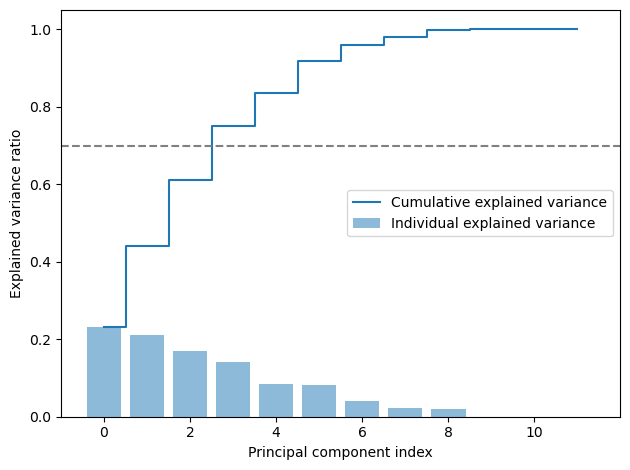

In [57]:
exp_var_pca = pca12.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.axhline(y=0.70, color='grey', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [58]:
np.set_printoptions(formatter={'float_kind': '{:f}'.format})

# Create DataFrame with cumulative sum of explained variance ratios
cumulative_explained_variance = np.cumsum(pca12.explained_variance_ratio_)
cumulative_explained_variance_df = pd.DataFrame(cumulative_explained_variance).T
cumulative_explained_variance_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.230872,0.441343,0.610782,0.751176,0.836822,0.918182,0.958817,0.980318,0.999639,0.999873,1.0,1.0


The total explained variance with 4 components is 75.1176%, an high level of information, that allows us to reduce the dimensionality from 12 to 4;
Choosing 5 or more principal components is not appropriate since 4 components are enough to tell the information well, and choosing 5 principal components brings an increase in information of 8.5647% (and by increasing the number of components the increase is vanishingly small) while moving away from our goal of dimensionality reduction; so for these reason we choose to use 4 as number of components.

In [59]:
pca4 = PCA(n_components=4)
principalComponents = pca4.fit_transform(df_no_missing)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3', 'PC4'])
principalDf.head()

,PC1,PC2,PC3,PC4
0,1.734473,2.424992,-2.051077,1.583022
1,-0.137552,0.636120,0.567204,-0.700009
2,-0.506598,-0.216392,-1.473276,-0.982193
3,1.663120,-2.252214,0.004477,0.987111
4,-0.763070,0.083894,-1.315145,-1.412428


### 2.3 Clustering!

#### 2.3.1. Implement the K-means clustering algorithm (not ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

In [26]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from random import sample
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from kneed import KneeLocator
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [27]:
#Load dataset
df_reduced = pd.read_csv('acp.csv')
df_reduced.head()

,PC1,PC2,PC3,PC4
0,1.734507,2.424997,-2.052931,1.582426
1,-0.137441,0.636176,0.565408,-0.700611
2,-0.506555,-0.216396,-1.475043,-0.982773
3,1.663221,-2.252168,0.002717,0.986513
4,-0.763159,0.083833,-1.314464,-1.412189


In [ ]:
#Build point of dataset
df_points = [tuple([round(x,2) for x in r]) for r in df_reduced.to_numpy()]

#Start and set Spark session
spark = SparkSession.builder.master("local").appName('Kmeans').getOrCreate()
sparkcontext = SparkContext.getOrCreate()
rdd = sparkcontext.parallelize(df_points)
#Repartition of data (100)
rdd = rdd.repartition(100)

# Reduce function
def reduce_f(x): 
    return (np.mean(list(x), axis=0).tolist(), x)

def kmeans_pyspark(rdd, reduce_f, k, points, max_iters=50):

    # Initialize centroids: randomly select k points
    centroids = sample(points, k)

    # Run MapReduce
    for i in range(max_iters):

        # Map: associate each point to the closest centroid
        map = rdd.map(lambda x: (centroids[np.argmin([np.sum((np.array(x)-np.array(c))**2) for c in centroids])], x))

        # Reduce: find new centroid for each cluster
        reduce = map.groupByKey().mapValues(reduce_f).values().collect()

        centroids = [tuple(x[0]) for x in reduce]
        clusters = [list(x[1]) for x in reduce]

    return centroids, clusters

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/17 17:53:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### 2.3.2. Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

In order to use K-means, it is necessary to find the natural number  of clusters of the data being examined. To do this there are several methods, some of the commonly used are:
- The Elbow Method, 
- The Silhouette Method
- The Calinski-Harabasz Index.

##### 1. Elbow Method

In [29]:
#Initialize Sum of Squared Error 'SSE' list
SSE = []

for k in range(1, 9):
    #We use KMeans function from 'sklearn' library
    kmeans = KMeans(n_clusters=k, init='random', max_iter=300, random_state=42)
    kmeans.fit(df_reduced)
    #We store SSE in its list
    SSE.append(kmeans.inertia_)

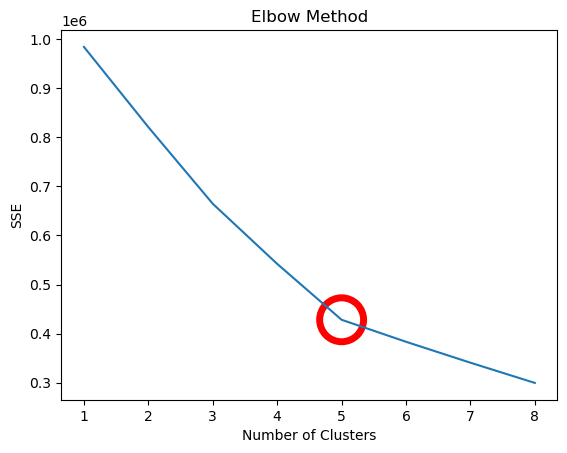

In [30]:
#Plot Elbow Method for different 'k'
plt.plot(range(1, 9), SSE)
plt.scatter(5,SSE[4], marker='o', facecolors='none', edgecolors='r',s=1000, linewidth=5)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [31]:
#Made another test for the calculation of 'k'
kl = KneeLocator(range(1,9), SSE, curve='convex', direction='decreasing')
print("The perfect 'k' (number of cluster) for Elbow Method is: %i" %kl.elbow)

The perfect 'k' (number of cluster) for Elbow Method is: 5


##### 2. Silhouette Method

In [32]:
#Initialize Silhouette Score 'sil_score' list
sil_score = []

for k in range(2, 9):
    #We use KMeans function from 'sklearn' library
    kmeans = KMeans(n_clusters=k, init='random', max_iter=300, random_state=42)
    kmeans.fit(df_reduced)
    #We store Sil. Score in its list
    sil_avg = silhouette_score(df_reduced, kmeans.labels_)
    sil_score.append(sil_avg)

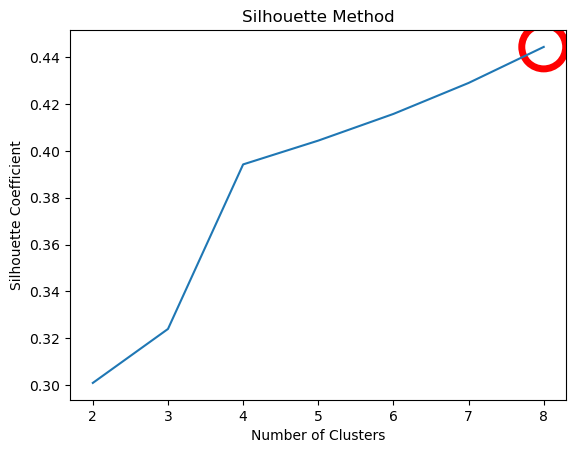

In [33]:
#Plot Silhouette Method for different 'k'
plt.plot(range(2, 9), sil_score)
plt.scatter(8,sil_score[6], marker='o', facecolors='none', edgecolors='r',s=1000, linewidth=5)
plt.title("Silhouette Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

##### 3. Calinski-Harabasz Index

In [34]:
#Initialize Calinski-Harabasz 'CH' Index list
CH = []

for k in range(2, 9):
    #We use KMeans function from 'sklearn' library
    kmeans = KMeans(n_clusters=k, init='random', max_iter=300, random_state=42)
    labels = kmeans.fit_predict(df_reduced)  
    #We store Calinski-Harabasz score in its list
    CH.append(metrics.calinski_harabasz_score(df_reduced, np.array(labels)))

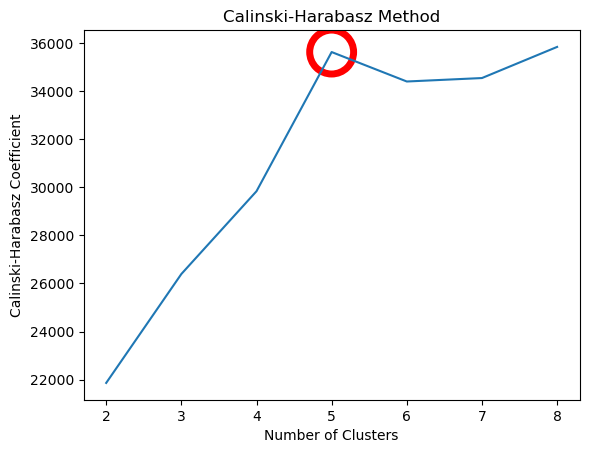

In [35]:
#Plot Calinski-Harabasz Index for different 'k'
plt.plot(range(2, 9), CH)
plt.scatter(5,CH[3], marker='o', facecolors='none', edgecolors='r',s=1000, linewidth=5)
plt.title("Calinski-Harabasz Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Coefficient")
plt.show()

##### **Explained Choice**

We decided to use the ***Calinski-Harabasz Index*** (in addition to ***Elbow*** and ***Silhouette Method***), because the two initial method were very discordant with each other. 
</br>

In fact, while *Elbow Method* tells us that the optimal number of clusters is equal to *5*, Silhouette Method tells us that the greater the number of clusters, the greater its effectiveness.
</br>

That is why we brought up the previously mentioned index (*Calinski-Harabasz*), which confirms what the *Elbow Method* said, that the optimal number of clusters within our data is 5, consequently we chose ***k = 5***

#### 2.3.3. Run the algorithm on the data obtained from the dimensionality reduction.

In [37]:
kmeans_results = {}

# Run K-means for different values of k
for k in range(3, 6+1):

    centroids, clusters = kmeans_pyspark(rdd, reduce_f, k, df_points, 50)

    clust_id = {}
    for i in range(k):
        for point in clusters[i]:
            clust_id[point] = i

    kmeans_results[k] = {"centroids": centroids, "clusters": [clust_id[point] for point in df_points]}

#### 2.3.4. Implement K-means++ from scratch and explain the differences with the results you got earlier.

In [38]:
df_points = [tuple([round(x, 2) for x in r]) for r in df_reduced.to_numpy()]

spark = SparkSession.builder.master("local").appName('Kmeans++').getOrCreate()
sparkcontext = SparkContext.getOrCreate()
rdd = sparkcontext.parallelize(df_points)
rdd = rdd.repartition(100)

def initialize_kmeans_plusplus(points, k):
    # Inizializza il primo centroide casualmente
    centroids = [points[np.random.randint(len(points))]]

    # Seleziona gli altri centroidi utilizzando K-means++
    for _ in range(1, k):
        distances = np.array([min([np.linalg.norm(np.array(point) - np.array(centroid))**2 for centroid in centroids]) for point in points])
        probabilities = distances / sum(distances)
        next_centroid_index = np.random.choice(len(points), p=probabilities)
        centroids.append(points[next_centroid_index])

    return centroids

# Reduce function
def reduce_f(x): 
    return (np.mean(list(x), axis=0).tolist(), x)

def kmeans_plusplus_pyspark(rdd, reduce_f, k, points, max_iters=50):
    # Inizializza i centroidi utilizzando K-means++
    centroids = initialize_kmeans_plusplus(points, k)

    # Run MapReduce
    for i in range(max_iters):
        # Map: associate each point to the closest centroid
        map_result = rdd.map(lambda x: (centroids[np.argmin([np.sum((np.array(x)-np.array(c))**2) for c in centroids])], x))

        # Reduce: find new centroid for each cluster
        reduce_result = map_result.groupByKey().mapValues(reduce_f).values().collect()

        centroids = [tuple(x[0]) for x in reduce_result]
        clusters = [list(x[1]) for x in reduce_result]

    return centroids, clusters

23/12/17 19:05:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [36]:
#Use our 'K-means' algorithm
result_centroids, result_clusters = kmeans_pyspark(rdd, reduce_f, k=5, points=df_points, max_iters=50)

23/12/17 18:02:47 WARN TaskSetManager: Stage 0 contains a task of very large size (8488 KiB). The maximum recommended task size is 1000 KiB.


In [39]:
#Use our 'K-means++' algorithm
result_centroids_pp, result_clusters_pp = kmeans_plusplus_pyspark(rdd, reduce_f, k=5, points=df_points, max_iters=50)

23/12/17 19:05:07 WARN TaskSetManager: Stage 750 contains a task of very large size (8488 KiB). The maximum recommended task size is 1000 KiB.


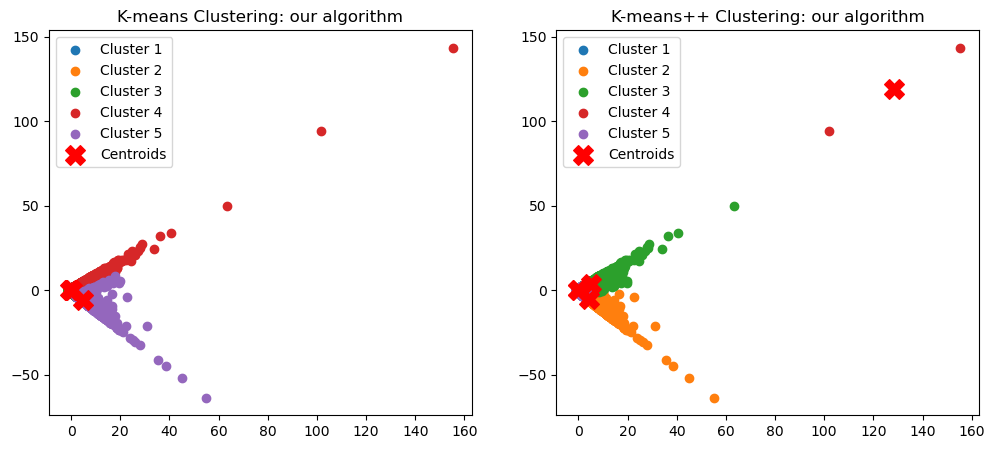

In [40]:
import matplotlib.pyplot as plt

def plot_clusters(ax, centroids, clusters, title):
    ax.set_title(title)
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}')
    centroid_points = np.array(centroids)
    ax.scatter(centroid_points[:, 0], centroid_points[:, 1], marker='X', s=200, c='red', label='Centroids')
    ax.legend()

# Esegui K-means
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_clusters(ax1, result_centroids, result_clusters, 'K-means Clustering: our algorithm')

# Esegui K-means++
plot_clusters(ax2, result_centroids_pp, result_clusters_pp, 'K-means++ Clustering: our algorithm')

plt.show()

As we can see, having an initialization of the contraids created differently in our two algorithms, the centroids are slightly different from each other. 

We then compared the fit of the data on our models, with those of sklearn. They are shown below:

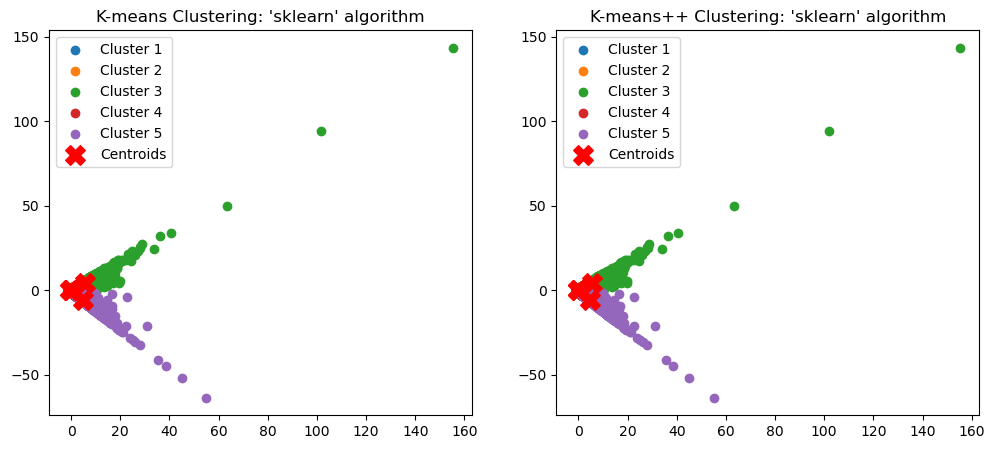

In [41]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

def plot_clusters(ax, centroids, labels, title):
    ax.set_title(title)
    for i in range(len(centroids)):
        cluster_points = df_reduced.iloc[labels == i]
        ax.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], label=f'Cluster {i + 1}')
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')
    ax.legend()

# Esegui K-means
kmeans_model = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans_model.fit_predict(df_reduced)
kmeans_centroids = kmeans_model.cluster_centers_

# Esegui K-means++
kmeans_pp_model = KMeans(n_clusters=5, init='k-means++', random_state=42)
kmeans_pp_labels = kmeans_pp_model.fit_predict(df_reduced)
kmeans_pp_centroids = kmeans_pp_model.cluster_centers_

# Plot dei risultati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_clusters(ax1, kmeans_centroids, kmeans_labels, "K-means Clustering: 'sklearn' algorithm")

plot_clusters(ax2, kmeans_pp_centroids, kmeans_pp_labels, "K-means++ Clustering: 'sklearn' algorithm")

plt.show()

Clusters in our algorithms change shape and centroids, unlike these algorithms in *sklearn*

#### 2.3.5. Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

In [132]:
from sklearn.mixture import GaussianMixture

#Gaussian Mixture Algorithm
gmm = GaussianMixture(n_components=5)
#Fit with our data
fitted = gmm.fit(df_reduced)

#Labels predict
labels = gmm.predict(df_reduced)

#Predict Probability
probs= gmm.predict_proba(df_reduced)

#Means
means = gmm.means_

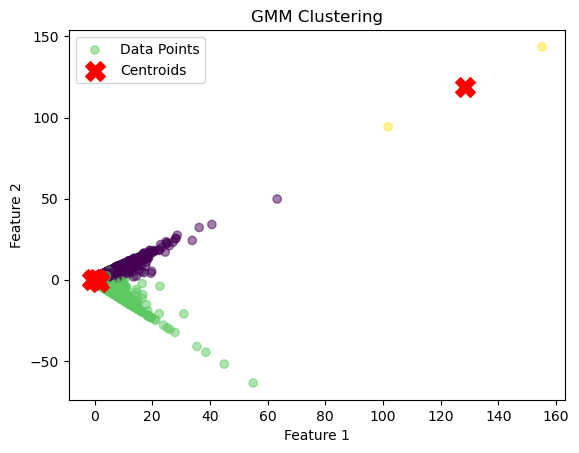

In [139]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_reduced has 2 features for easy visualization
# Replace 'feature1' and 'feature2' with the actual feature names in your DataFrame
feature1 = df_reduced.iloc[:, 0]
feature2 = df_reduced.iloc[:, 1]

# Plot the points
plt.scatter(feature1, feature2, c=labels, cmap='viridis', alpha=0.5, label='Data Points')

# Plot the centroids
plt.scatter(means[:, 0], means[:, 1], c='red', marker='X', s=200, label='Centroids')

# Customize the plot
plt.title('GMM Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


As we note from the plot, this form of visualization is very close to our implementation of 'K-Means++'. It can be seen from the fact that the centroid in the upper right leads to having a cluster in the upper right. In this case we can notice it by the yellow color, in our implementation of 'K-means++' by the red color
</br>

Therefore we think that, the 'K-Means' of our implementation, and 'K-Means' and 'K-Means++' of the sklearn library are better than this.

### 2.4 Analysing your results! --


#### 2.4.1. Select 2-3 variables you think are relevant to identify the cluster of the customer. For example, Time_Day, Average Click Duration, etc.

We chose 4 variables in our dataset, which in our opinion, may be the most relevant, because represent 3 different aspects of each user's behavior on the platform:

- '*fav_filmera*' (Favourite Film Era by each user), 
- '*duration_avg*' (Average Duration of all watched film by each user), 
- '*duration_sum*' (Sum Duration of all watched film per day by each user)
- '*fav_timeofday*' (Favourite time of day)

In [115]:
df2 = pd.read_csv('df2.csv')
sel_df = df2[['fav_filmera','duration_avg','duration_sum','fav_timeofday']]

sel_df['fav_filmera'] = sel_df['fav_filmera'].astype(str).apply(lambda x: x[:-2] if x.endswith('.5') else x).astype(float)
sel_df['fav_timeofday'] = sel_df['fav_timeofday'].astype(str).apply(lambda x: x[:-2] if x.endswith('.5') else x).astype(float)

sel_df.head()

,fav_filmera,duration_avg,duration_sum,fav_timeofday
0,0.0,3470.0,48580.0,2.0
1,1.0,19327.0,77308.0,3.0
2,1.0,83625.0,83625.0,2.0
3,0.0,473682.5,947365.0,2.0
4,1.0,14394.0,14394.0,2.0


#### 2.4.2/2.4.3/2.4.4/2.4.5. Most of your selected variables will be numerical (continuous or discrete), then categorize them into four categories / With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable / Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100 [...]. / Interpret the results for each pivot table.

In [116]:
#add  new column to the data that includes the cluster to which belongs a customer.
sel_df["Cluster"] = kmeans_results[5]["clusters"]
sel_df.head()

,fav_filmera,duration_avg,duration_sum,fav_timeofday,Cluster
0,0.0,3470.0,48580.0,2.0,0
1,1.0,19327.0,77308.0,3.0,1
2,1.0,83625.0,83625.0,2.0,2
3,0.0,473682.5,947365.0,2.0,0
4,1.0,14394.0,14394.0,2.0,2


In [117]:
customers = sel_df
customers['q_duration_avg'] = pd.qcut(customers['duration_avg'], q=[0, 0.25, 0.5, 0.75, 1.0], labels=['Q1', 'Q2', 'Q3', 'Q4'])
customers['q_duration_sum'] = pd.qcut(customers['duration_sum'], q=[0, 0.25, 0.5, 0.75, 1.0], labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [118]:
personalized = sel_df
personalized['fav_filmera'] = personalized['fav_filmera'].replace(0.0, 'Old')
personalized['fav_filmera'] = personalized['fav_filmera'].replace(1.0, 'New')

personalized['fav_timeofday'] = personalized['fav_timeofday'].replace(1.0, 'Morning')
personalized['fav_timeofday'] = personalized['fav_timeofday'].replace(2.0, 'Afternoon')
personalized['fav_timeofday'] = personalized['fav_timeofday'].replace(3.0, 'Night')

In [120]:
#plotting the tables
df1 = round(100*personalized.groupby('Cluster')["fav_filmera"].value_counts(normalize = True).unstack().fillna(0),2)
df2 = round(100*customers.groupby('Cluster')["q_duration_avg"].value_counts(normalize = True).unstack().fillna(0),2)
df3 = round(100*customers.groupby('Cluster')["q_duration_sum"].value_counts(normalize = True).unstack().fillna(0),2)
df4 = round(100*personalized.groupby('Cluster')["fav_timeofday"].value_counts(normalize = True).unstack().fillna(0),2)

In [126]:
d5 = customers.Cluster.value_counts().sort_index().to_frame().rename({"Cluster": "Nº people"}, axis = 1)

##### Favourite Film Era

In [121]:
df1

fav_filmera,New,Old
Cluster,,
0,0.24,99.76
1,95.47,4.53
2,92.97,7.03
3,89.76,10.24
4,75.67,24.33


- In **Cluster 0**, we have almost 100% lovers of 'Old' movies.
- In **Cluster 1**, on the contrary, we have lovers of 'New' movies with a small appreciation of 'Old' as well (almost 5%).
- In **Cluster 2**, like the previous cluster, but the percentage of appreciation of 'Old' increases to 7%.
- In **Cluster 3**, same as the previous two clusters, but the percentage appreciation of 'Old' grows even more to 10.24%.
- In **Cluster 4**, like the previous three clusters, this cluster has as 'User' users who appreciate 'New' movies the most, but the percentage of almost 25% of 'Old' movies viewed is certainly not insignificant

##### Click Duration Average

In [122]:
df2

q_duration_avg,Q1,Q2,Q3,Q4
Cluster,,,,
0,24.98,25.39,25.46,24.18
1,26.36,25.96,25.01,22.67
2,26.56,24.42,25.06,23.96
3,4.58,35.64,48.53,11.25
4,0.00,0.00,0.00,100.00


- ***The first three Clusters*** are evenly distributed, unlike *Cluster 3* and *Cluster 4*. 
- In **Cluster 3** we see a strong presence of users between the second quartile and the third quartile (with a pronounced prevalence in the third quartile). This explains that a high percentage of users, on average watch movies for as long as the average of all users.
- In **Cluster 4** on the other hand, there is a total belonging of the users to the fourth quartile (100%). Users belonging to this Cluster watch the movie on average longer than the others.

##### Duration Sum

In [123]:
df3

q_duration_sum,Q1,Q2,Q3,Q4
Cluster,,,,
0,26.04,26.63,26.38,20.95
1,26.51,26.58,26.04,20.87
2,25.89,25.22,25.60,23.29
3,0.25,1.64,11.17,86.95
4,0.00,0.00,0.00,100.00


- ***The first three clusters*** are evenly distributed, unlike *Cluster 3* and *Cluster 4*. 
- In **Cluster 3**, we see a strong presence of users in the fourth quartile, almost 87% of users. This can certainly explain that, users belonging to this cluster spend much more time on the platform than the others.
- In **Cluster 4**, on the other hand, there is a total presence of users in the fourth quartile (100%)

##### Favourite Time of Day

In [106]:
df4

fav_timeofday,Afternoon,Morning,Night
Cluster,,,
0,46.83,10.58,42.59
1,48.37,11.21,40.42
2,49.03,10.89,40.09
3,48.47,6.96,44.58
4,44.14,10.38,45.48


From these clusters, we cannot show any difference except for some minimal percentage among users. In fact, all users watch significantly more movies in 'Afternoon' - 'Night'

##### **Users in Clusters**

In [128]:
d5

,count
Cluster,
0,20759
1,54484
2,29301
3,2444
4,2773


Users in the clusters seem to be more evenly distributed for the first three clusters

#### 2.4.6. Use any known metrics to estimate clustering algorithm performance (how good are the clusters you found?). Comment on the results obtained.

As explained earlier in Section 2.3.2, in searching for an optimal value for the number of clusters, we used the two methods Elbow and Silhouette.
Having conflicting opinions, we used Calinski-Harabasz Index for more confirmation of the value.
</br>

For further verification of the obtained cluster value, we use another index: **Davies-Bouldin Index**.

In [129]:
#Initialize Davies-Bouldin 'DB' Index list
DB = []

for k in range(2, 9):
    #We use KMeans function from 'sklearn' library
    kmeans = KMeans(n_clusters=k, init='random', max_iter=300, random_state=42)
    labels = kmeans.fit_predict(df_reduced)  
    #We store Davies-Bouldin score in its list
    DB.append(metrics.davies_bouldin_score(df_reduced, np.array(labels)))

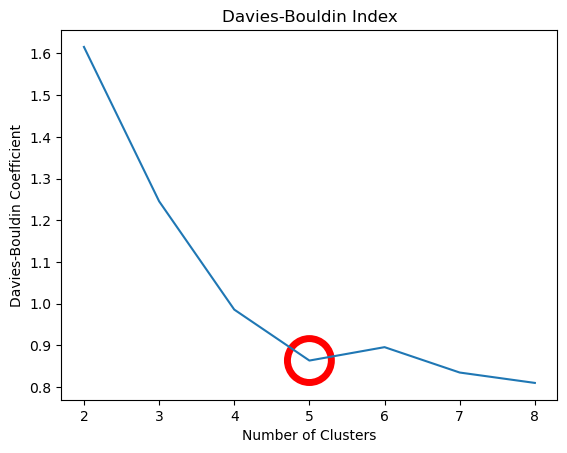

In [131]:
#Plot Davies-Bouldin Index for different 'k'
plt.plot(range(2, 9), DB)
plt.scatter(5,DB[3], marker='o', facecolors='none', edgecolors='r',s=1000, linewidth=5)
plt.title("Davies-Bouldin Index")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Coefficient")
plt.show()

The optimal value for the cluster number, also recommended by this index is **k = 5**. Our analysis is correct.

## 4. Command Line Question (CLQ)


Here is another command line question to enjoy. We previously stated that using the command line tools is a skill that Data Scientists must master.

In this question, you should use any command line tool that you know to answer the following questions using the same dataset that you have been using so far:

- What is the most-watched Netflix title?
- Report the average time between subsequent clicks on Netflix.com
- Provide the ID of the user that has spent the most time on Netflix

Important note: You may work on this question in any environment (AWS, your PC command line, Jupyter notebook, etc.), but the final script must be placed in CommandLine.sh, which must be executable. Please run the script and include a screenshot of the output in the notebook for evaluation.

**If the picture does not load on Github, we have attached a CLQ.png file with the caputra of the outputs in the repository.**

![foto](CLQ.png)

## 5. Algorithmic Question (AQ)

Federico studies in a demanding university where he has to take a certain number N of exams to graduate, but he is free to choose in which order he will take these exams. Federico is panicking since this university is not only one of the toughest in the world but also one of the weirdest. His final grade won't depend at all on the mark he gets in these courses: there's a precise evaluation system.

He was given an initial personal score of S when he enrolled, which changes every time he takes an exam: now comes the crazy part. He soon discovered that every of the N exams he has to take is assigned a mark p. Once he has chosen an exam, his score becomes equal to the mark p, and at the same time, the scoring system changes:

- If he takes an "easy" exam (the score of the exam being less than his score), every other exam's mark is increased by the quantity S - p

- If he takes a "hard" exam (the score of the exam is greater than his score), every other exam's mark is decreased by the quantity p - S

So, for example, consider S = 8 as the initial personal score. Federico must decide which exam he wants to take, being [5, 7, 1] the marks list. If he takes the first one, being 5 < 8 and 8 - 5 = 3, the remaining list now becomes [10, 4], and his score is updated as S = .

In this chaotic university where the only real exam seems to be choosing the best way to take exams, you are the poor student advisor who is facing a long queue of confused people who need some help. Federico is next in line, and he comes up in turn with an inescapable question: he wants to know which is the highest score possible he could get.

a) Fortunately, you have a computer app designed by a brilliant student. Federico wants you to show him the code which this app is based on because he wants to do paid counseling for other desperate students: in a recursive fashion, the helped helps the helpable.

In [1]:
from itertools import zip_longest
#initial personal score
S=int(input())
# marks
exams_grades=list(map(int,input().split()))
exams_grades.sort()
#we create 2 list where we put the greatest and smallest numbers
l1=exams_grades[:len(exams_grades)//2]
l2=exams_grades[len(exams_grades)//2:]
#we create a new list with an element from the list of the greatest numbers and an element from the list of the smallest numbers
if len(l2)==len(l1):
  new_list = [elemento for val in zip_longest(l1, l2) for elemento in val]
else:
  new_list = [elemento for val in zip_longest(l2, l1) for elemento in val if elemento is not None]

# we update the marks according to the rule given by the university
for x in range(len(new_list)):
  grade=new_list[x]
  diff=S-grade
  for y in range(x+1,len(new_list)):
      new_list[y]+=diff
  S=grade
print(S)

30
13 27 41 59 28 33 39 19 52 48 55 79
205


b) Federico is getting angry because he claims that your code is slow! Show him formally with a big-O notation that he is as crazy as this university!

### Time Complexity Analysis


**Input Reading**:
Reading
S and
exams_grades
exams_grades takes constant time, so the complexity is O(1).

**List Sorting**: Sorting the list
exams_grades has a time complexity of
O(nlogn), where
n is the length of exams_grades.

**Creating new_list** : The creation of new_list is performed once and has a linear time complexity relative to the length of the list. Therefore, it is
O(n).

**Updating Marks**: The time complexity analysis for the updating marks part is as follows:

- The outer loop runs N times.
- The inner loop also runs, on average, N/2 times across all iterations of the outer loop.
- Inside the inner loop, updating the elements of `new_list` takes constant time, O(1).
- Therefore, the total time complexity for this part is O(N^2).

**In conclusion** : Considering both factors, the overall time complexity of the provided code is dominated by the quadratic term, resulting in a final time complexity of O(N^2) due to the updating marks part.


c) If, unfortunately, Federico is right in the grip of madness, he will threaten you to optimize the code through a different approach. You should end this theater of the absurd by any means! (And again, formally prove that you improved time complexity)

In [2]:
def best_grade_improved(S=int(input()),exams_grades=list(map(int, input().split()))):
    exams_grades.sort()
    n = len(exams_grades)
    l1 = exams_grades[:n//2]
    l2 = exams_grades[n//2:]
# if the number of the exams is even or odd we have to create the list in a different way
    if n % 2 == 0:
        new_list = [elemento for val in zip_longest(l1, l2) for elemento in val]
    else:
        new_list = [elemento for val in zip_longest(l2, l1) for elemento in val if elemento is not None]
    # after have put the marks in a proper way we call the recursive function to find the best final grade
    adjust_grades_recursive(S, new_list)


def adjust_grades_recursive(S, exams_grades_systemed):
    if not exams_grades_systemed:
        print(S)
        return
    grade = exams_grades_systemed[0]
    diff=S-grade
    # we update the marks according to the rule given by the university
    for y in range(1, len(exams_grades_systemed)):
      exams_grades_systemed[y] += diff
    S = grade
    adjust_grades_recursive(S, exams_grades_systemed[1:])


best_grade_improved()

30
13 27 41 59 28 33 39 19 52 48 55 79
205


### Time Complexity Analysis

1. **Input Reading and List Sorting:**
   - Reading the personal score `S` and creating the `exams_grades` list take O(N) time.
   - Sorting the `exams_grades` list takes O(N log N) time.

2. **Creating Lists `l1` and `l2`:**
   - Creating `l1` and `l2` by slicing the sorted list takes O(N) time.

3. **Creating `new_list`:**
   - Creating `new_list` using `zip_longest` and list comprehensions takes O(N) time.

4. **Recursive Grade Adjustment:**
   - The recursive function `adjust_grades_recursive` processes each element of `exams_grades_systemed` once.
   - In each iteration, the function performs constant-time operations (O(1)).
   - In the worst case, the recursion depth is N.
   - Therefore, the total time complexity for this part is O(N).

Considering the sorting operation, the overall time complexity of the improved code is O(N log N) due to the dominant sorting step.

So this is more efficient because to update marks has a complexity of O(N) and not O(N^2) as in the former version.

d) Ask chatGPT for a third (optimized) implementation and analyze again its time complexity. Be careful (and crafty) in defining the prompt, and challenge the machine in this coding question!

In [4]:
from statistics import median
def best_grade_improved_chatgpt(S=int(input()), exams_grades=list(map(int, input().split()))):
  # we use the median to split the exams_grades in two list one with the largest numbers and the other one with the smallest number
    median_value = median(exams_grades)

    l1 = [element for element in exams_grades if element < median_value]

    l2 = [element for element in exams_grades if element >= median_value]

    if len(l2)==len(l1):
        new_list = [elemento for val in zip_longest(l1, l2) for elemento in val]
    else:
        new_list = [elemento for val in zip_longest(l2, l1) for elemento in val if elemento is not None]

    adjust_grades_recursive(S, new_list)

def adjust_grades_recursive(S, exams_grades_systemed):
    if not exams_grades_systemed:
        print(S)
        return
    grade = exams_grades_systemed[0]
    diff = S - grade
    for y in range(1, len(exams_grades_systemed)):
        exams_grades_systemed[y] += diff
    S = grade
    adjust_grades_recursive(S, exams_grades_systemed[1:])

best_grade_improved_chatgpt()

30
13 27 41 59 28 33 39 19 52 48 55 79
205


Here are some input/output examples (the first value is the initial personal score, and the second line contains the list of marks):

#### Input 1

8

5 7 1 

#### Output 1

11

#### Input 2

25

18 24 21 32 27

#### Output 2

44

#### Input 3

30

13 27 41 59 28 33 39 19 52 48 55 79

#### Output 3



205